# Autores
- Javier Abella
- Victor Teixidó
- Tomas Treviño
- You Wu

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

!pip install apafib --upgrade --user --quiet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import set_config
import warnings
set_config(display='text')
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

from mpl_toolkits.mplot3d import Axes3D

from yellowbrick.regressor import AlphaSelection
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Predicción del uso de bicicletas

El uso compartido de bicicletas es un servicio proporcionado por cualquier ciudad importante del mundo, por lo que comprender y predecir el comportamiento del sistema es un elemento clave. Vamos a trabajar con el conjunto de datos de bicicletas compartidas del repositorio de conjuntos de datos de UCI que recopila estadísticas agregadas de uso de bicicletas junto con otra información adicional relevante.

El objetivo de este problema es predecir cuántas bicicletas se usarán diariamente.

In [ ]:
from zipfile import ZipFile
from io import BytesIO
import urllib.request as urllib2

url = urllib2.urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip").read()
file = ZipFile(BytesIO(url))
day_csv = file.open("day.csv")

bikes_data = pd.read_csv(day_csv)
bikes_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344,0.364,0.806,0.160,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363,0.354,0.696,0.249,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196,0.189,0.437,0.248,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200,0.212,0.590,0.160,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.227,0.229,0.437,0.187,82,1518,1600


## Apartado a

El primer paso es hacer una pequeña exploración del conjunto de datos de entrenamiento observando las relaciones entre las variables, especialmente con la variable objetivo. Dividiremos los datos en dos conjuntos, el de entrenamiento y el de test. Preprocesaremos y prepararemos los datos antes de ajustar cualquier modelo. Eliminaremos aquellas variables que no son útiles para el problema o que no tiene sentido usar y trataremos los datos en caso de que sea necesario. Por último, estandarizaremos las variables y aplicaremos el preprocesado y la estandarización a los datos de test.


In [ ]:
bikes_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
instant,731.0,NaN,NaN,NaN,366.0,211.166,1.0,183.5,366.0,548.5,731.0
dteday,731,731,2011-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,731.0,NaN,NaN,NaN,2.497,1.111,1.0,2.0,3.0,3.0,4.0
yr,731.0,NaN,NaN,NaN,0.501,0.5,0.0,0.0,1.0,1.0,1.0
mnth,731.0,NaN,NaN,NaN,6.52,3.452,1.0,4.0,7.0,10.0,12.0
holiday,731.0,NaN,NaN,NaN,0.029,0.167,0.0,0.0,0.0,0.0,1.0
weekday,731.0,NaN,NaN,NaN,2.997,2.005,0.0,1.0,3.0,5.0,6.0
workingday,731.0,NaN,NaN,NaN,0.684,0.465,0.0,0.0,1.0,1.0,1.0
weathersit,731.0,NaN,NaN,NaN,1.395,0.545,1.0,1.0,1.0,2.0,3.0
temp,731.0,NaN,NaN,NaN,0.495,0.183,0.059,0.337,0.498,0.655,0.862


A primera vista podemos observar como todos los atributos son tratados como númericos a pesar de que no todos lo son.

### Visualización de los datos

Primero de todo vamos a visualizar el comportamiento de los datos tanto individualemte como relacionados con la variable objetivo, para ver si encontramos patrones o características destacables.

#### Variables númericas

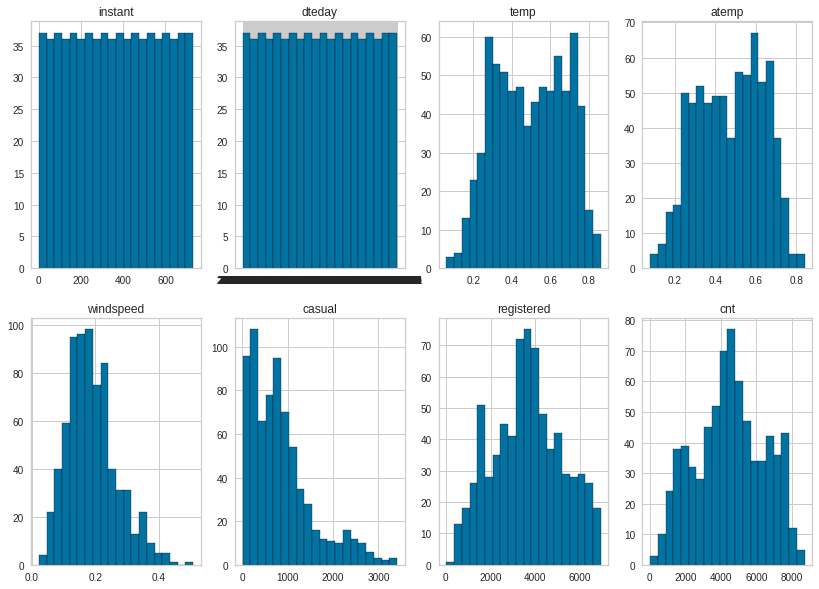

In [ ]:
fig,ax = plt.subplots(2,4,figsize=(14,10))

ax[0][0].hist(bikes_data['instant'], bins=20, edgecolor='black');
ax[0][0].set_title('instant');
ax[0][1].hist(bikes_data['dteday'], bins=20, edgecolor='black');
ax[0][1].set_title('dteday');
ax[0][2].hist(bikes_data['temp'], bins=20, edgecolor='black');
ax[0][2].set_title('temp');
ax[0][3].hist(bikes_data['atemp'], bins=20, edgecolor='black');
ax[0][3].set_title('atemp');

ax[1][0].hist(bikes_data['windspeed'], bins=20, edgecolor='black');
ax[1][0].set_title('windspeed');
ax[1][1].hist(bikes_data['casual'], bins=20, edgecolor='black');
ax[1][1].set_title('casual');
ax[1][2].hist(bikes_data['registered'], bins=20, edgecolor='black');
ax[1][2].set_title('registered');
ax[1][3].hist(bikes_data['cnt'], bins=20, edgecolor='black');
ax[1][3].set_title('cnt');

Se puede ver como las variables *instant* y *dteday*, no nos van a proporcionar información útil en nuestro modelo, por tanto, las eliminaremos del conjunto de datos durante el preprocessing. 

Podemos destacar que hay dos tipos de variables, las que muestran una cantidad de conteos y las que definen una medida. Las segundas, que son las variables *temp*, *atemp*, *hum* y *windspeed*, podemos ver que tienen un valor de rangos entre 0 y 1.

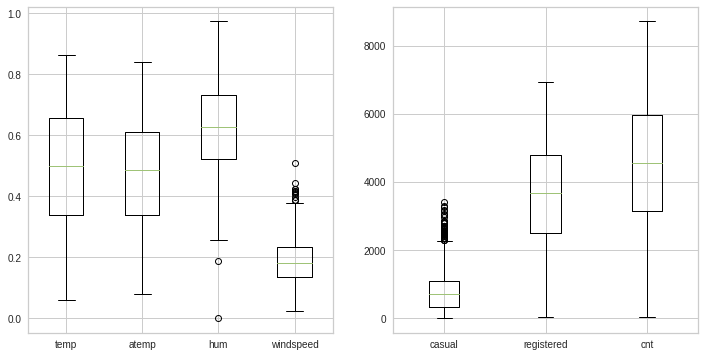

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

boxplot_data = [bikes_data['temp'],bikes_data['atemp'],bikes_data['hum'],bikes_data['windspeed']]
ax[0].boxplot(boxplot_data, labels=['temp','atemp','hum','windspeed']);

boxplot_data = [bikes_data['casual'],bikes_data['registered'],bikes_data['cnt']]
ax[1].boxplot(boxplot_data, labels=['casual','registered','cnt']);

A través de los boxplots, vemos como la variabilidad de cada una de las variables es pequeña. Como podemos ver, los atributos *casual* y *windspeed*, tienen valores atípicos. Aún así, hemos decidido dejarlos ya que podrían aportar información útil a la hora de definir los modelos.

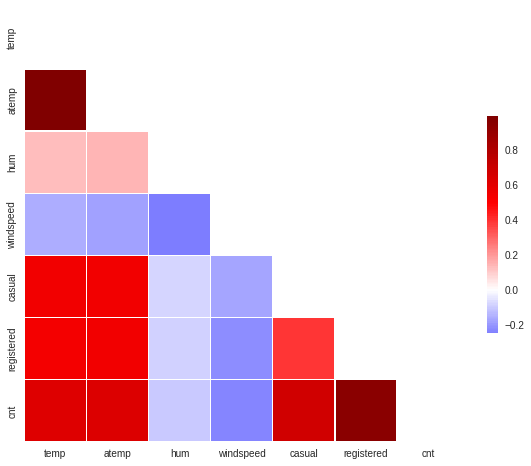

In [ ]:
numerical_columns = ['temp','atemp','hum','windspeed','casual','registered','cnt']

corr = bikes_data[numerical_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

En esta figura podemos ver la correlación entre los distintos atributos númericos. Como parece lógico, el número de usuarios, tanto registrados como casuales, tiene una alta correlación con la variable objetivo y es que estos atributos sumados, son igual a la variable objetivo. Estos dos atributos los eliminaremos durante el preprocessing por ese mismo motivo. Por otra parte, vemos como los distintos parámetros de medida de la temperatura parecen tener una significativa correlación con el número de bicicletas usadas.

#### Variables categóricas

3    188
2    184
1    181
4    178
Name: season, dtype: int64


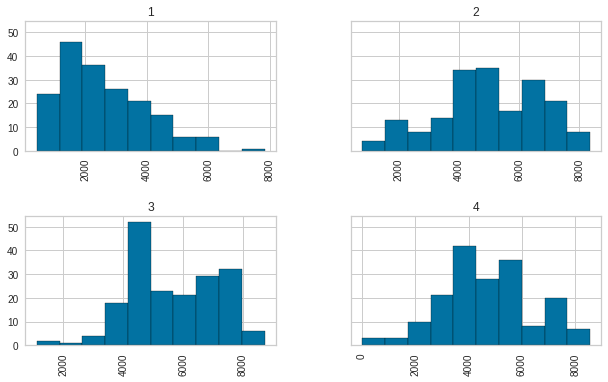

In [ ]:
# Podriamos poner de titulo el nombre de la estacion, si os poneis con esto me avisais y lo hago yo si me lo confirmais (Tomi)
print(bikes_data['season'].value_counts())

bikes_data.hist(column='cnt',by='season',bins=10, sharey=True, figsize=(10,6), edgecolor='black');

Así a simple vista, vemos como en Primavera (2) y en Verano (3) parece ser que se usan más bicicletas. Aún así, no parece haber una gran diferencia entre épocas del año. Modificaremos los valores con one-hot enconding para poder ajustar los distintos modelos. One-hot encoding porque no existe ningun tipo de prioridad u orden entre las distintas estaciones del año.

1    366
0    365
Name: yr, dtype: int64


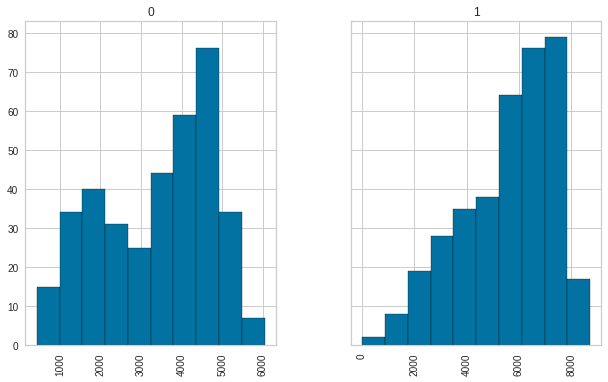

In [ ]:
print(bikes_data['yr'].value_counts())

bikes_data.hist(column='cnt',by='yr',bins=10, sharey=True, figsize=(10,6), edgecolor='black');

Entre los años 2011 y 2012 no parece haber una gran diferencia entre el uso de bicicletas.

1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     57
Name: mnth, dtype: int64


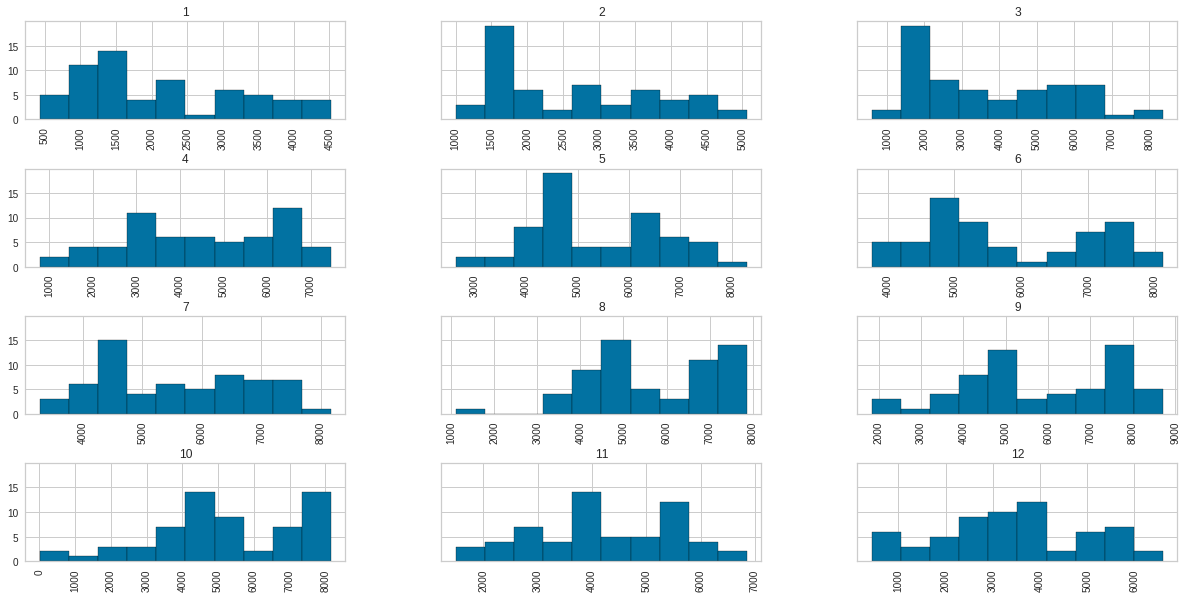

In [ ]:
print(bikes_data['mnth'].value_counts())

bikes_data.hist(column='cnt',by='mnth',bins=10, sharey=True, figsize=(20,10), edgecolor='black');

Parece haber una tendencia en los meses de Verano y Primavera en la que se usan más bicicletas en comparación a otros meses del año, tal y como veíamos antes. Modificaremos los valores con one-hot enconding para poder ajustar los distintos modelos. One-hot encoding porque no existe ningun tipo de prioridad u orden entre los distintos meses del año.

0    710
1     21
Name: holiday, dtype: int64


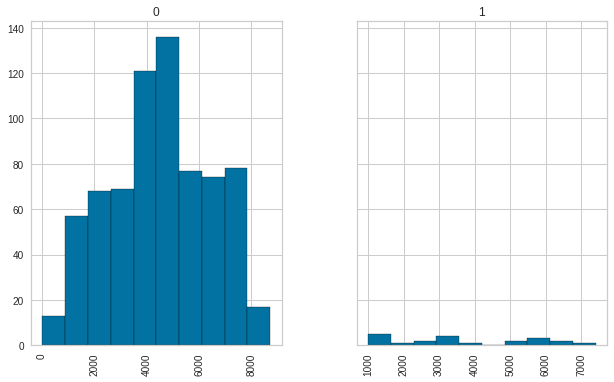

In [ ]:
print(bikes_data['holiday'].value_counts())

bikes_data.hist(column='cnt',by='holiday',bins=10, sharey=True, figsize=(10,6), edgecolor='black');

A posteriori, modificaremos el nombre de esta variable para que sea más representativa. Claramente vemos como en festivo se utilizan muchas menos bicicletas.

6    105
0    105
1    105
2    104
3    104
4    104
5    104
Name: weekday, dtype: int64


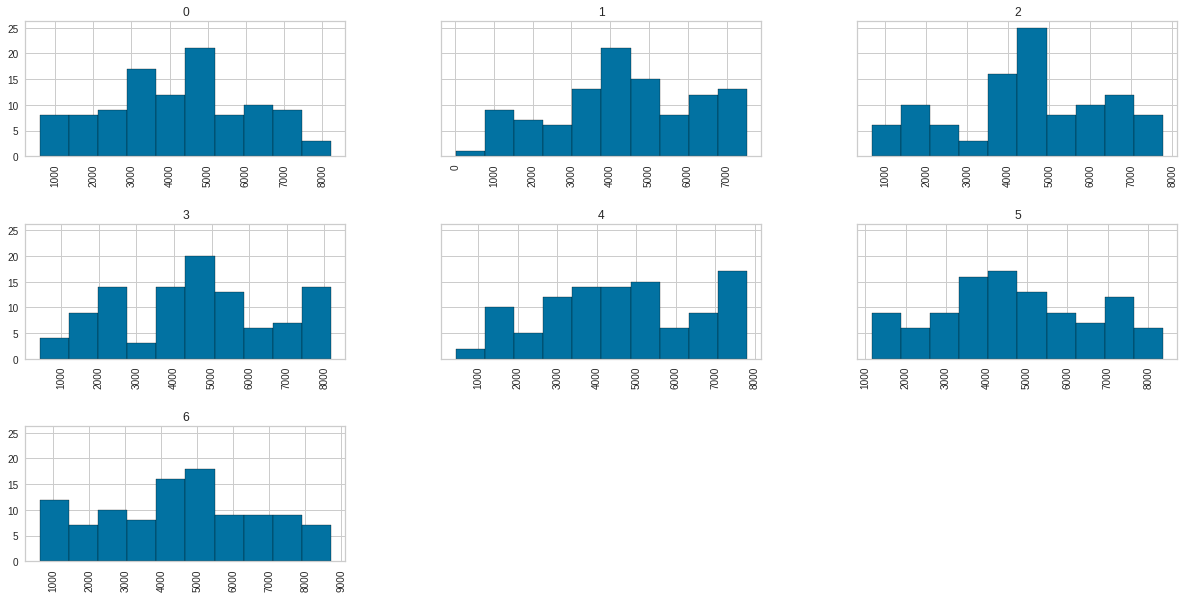

In [ ]:
print(bikes_data['weekday'].value_counts())

bikes_data.hist(column='cnt',by='weekday',bins=10, sharey=True, figsize=(20,10), edgecolor='black');

Parece haber un ligero mayor uso de bicicletas a principio de semana. Utilizaremos estos valores a la hora de ajustar los modelos.

1    500
0    231
Name: workingday, dtype: int64


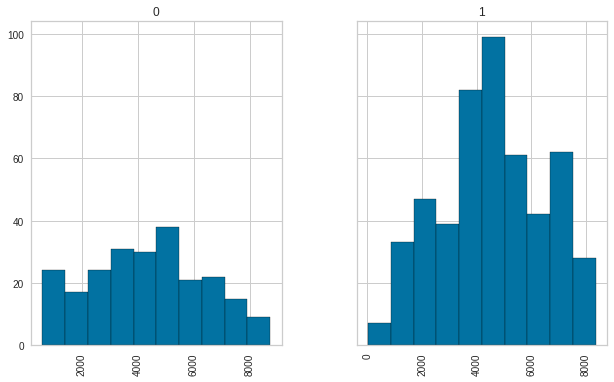

In [ ]:
print(bikes_data['workingday'].value_counts())

bikes_data.hist(column='cnt',by='workingday',bins=10, sharey=True, figsize=(10,6), edgecolor='black');

A posteriori, modificaremos el nombre de esta variable para que sea más representativa. Así a simple vista, vemos como cuando es dia laborable, el uso de bicicletas incrementa considerablemente.

1    463
2    247
3     21
Name: weathersit, dtype: int64


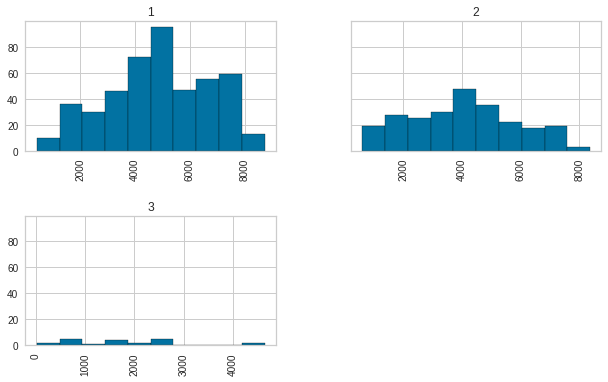

In [ ]:
print(bikes_data['weathersit'].value_counts())

bikes_data.hist(column='cnt',by='weathersit',bins=10, sharey=True, figsize=(10,6), edgecolor='black');

Así a simple vista, vemos como en hay leve lluvia o nieve (3) el uso de bicicletas es practicamente nulo. Modificaremos los valores con one-hot enconding para poder ajustar los distintos modelos. One-hot encoding porque no existe ningun tipo de prioridad u orden entre los distintos climas.

### División de los datos

Dividimos los datos en conjuntos de entrenamiento y test (60%/40%).

In [ ]:
from sklearn.model_selection import train_test_split

X = bikes_data.loc[:, bikes_data.columns != 'cnt']
y = bikes_data['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=33)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(438, 15) (438,)
(293, 15) (293,)


### Preprocessing

Durante el preprocessing vamos a eliminar las variables *instant* y *dteday* porque no son útiles a la hora de ajustar los distintos modelos. También renombramos algunas de las variables para obtener una mayor claridad. Además, para poder utilizar los datos a la hora de ajustar modelos, transformaremos las variables categóricas que haya para poder utilizarlas en los modelos y eliminaremos los valores que sean na.

In [ ]:
def minimum_preprocessing(X, y):
  print('Tamaño original:{}'.format(X.shape))

  # rename some variables
  X.rename({'yr': 'year', 'mnth': 'month', 'holiday': 'is_holiday', 'workingday': 'is_workingday',
                   'weathersit': 'weather_situation', 'windspeed': 'wind_speed'},
                  axis=1, inplace=True)
  
  # one-hot encoding month and season variables
  month_dummies = pd.get_dummies(X['month'], prefix='month', drop_first=True)
  season_dummies = pd.get_dummies(X['season'], prefix='season', drop_first=True)
  weather_dummies = pd.get_dummies(X['weather_situation'], prefix='weather', drop_first=True)
  X = pd.concat([X, month_dummies, season_dummies, weather_dummies], axis=1)
  
  # remove instant, dteday, month and season columns
  X.drop(columns=['instant','dteday','month','season','weather_situation','casual','registered'], inplace=True)

  # remove categorical variables
  categorical_columns = X.dtypes[X.dtypes=='category'].index.values
  X.drop(columns=categorical_columns, inplace=True)
  print('Eliminadas:{}'.format(categorical_columns))

  # remove possible missing values
  X = X.dropna()
  y = y[X.index]
  print('Nuevo tamaño:{}'.format(X.shape))
  return X, y

Vamos a aplicar el preprocessing especificado tanto al conjunto de entrenamiento como al conjunto de test.

In [ ]:
X_train, y_train = minimum_preprocessing(X_train,y_train)
print()
X_test, y_test = minimum_preprocessing(X_test,y_test)

Tamaño original:(438, 15)
Eliminadas:[]
Nuevo tamaño:(438, 24)

Tamaño original:(293, 15)
Eliminadas:[]
Nuevo tamaño:(293, 24)


In [ ]:
X_train.head()

,year,is_holiday,weekday,is_workingday,temp,atemp,hum,wind_speed,month_2,month_3,...,month_8,month_9,month_10,month_11,month_12,season_2,season_3,season_4,weather_2,weather_3
589,1,0,0,0,0.701,0.645,0.530,0.123,0,0,...,1,0,0,0,0,0,1,0,0,0
411,1,0,4,1,0.317,0.330,0.753,0.091,1,0,...,0,0,0,0,0,0,0,0,1,0
282,0,1,1,0,0.571,0.543,0.734,0.042,0,0,...,0,0,1,0,0,0,0,1,0,0
497,1,0,6,0,0.564,0.545,0.480,0.123,0,0,...,0,0,0,0,0,1,0,0,0,0
310,0,0,1,1,0.395,0.401,0.759,0.057,0,0,...,0,0,0,1,0,0,0,1,0,0


El siguiente y último paso para dejar los conjuntos de datos listos para el ajuste de los distintos modelos, es la estandarización de los datos.

In [ ]:
scaler = StandardScaler()

X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

X_train

,year,is_holiday,weekday,is_workingday,temp,atemp,hum,wind_speed,month_2,month_3,...,month_8,month_9,month_10,month_11,month_12,season_2,season_3,season_4,weather_2,weather_3
589,0.995,-0.136,-1.567,-1.548,1.112,1.035,-0.648,-0.952,-0.313,-0.33,...,3.199,-0.281,-0.281,-0.271,-0.304,-0.583,1.686,-0.537,-0.744,-0.153
411,0.995,-0.136,0.474,0.646,-0.962,-0.866,0.876,-1.356,3.199,-0.33,...,-0.313,-0.281,-0.281,-0.271,-0.304,-0.583,-0.593,-0.537,1.345,-0.153
282,-1.005,7.331,-1.056,-1.548,0.410,0.420,0.745,-1.995,-0.313,-0.33,...,-0.313,-0.281,3.562,-0.271,-0.304,-0.583,-0.593,1.863,-0.744,-0.153
497,0.995,-0.136,1.494,-1.548,0.374,0.432,-0.991,-0.944,-0.313,-0.33,...,-0.313,-0.281,-0.281,-0.271,-0.304,1.716,-0.593,-0.537,-0.744,-0.153
310,-1.005,-0.136,-1.056,0.646,-0.539,-0.438,0.916,-1.801,-0.313,-0.33,...,-0.313,-0.281,-0.281,3.688,-0.304,-0.583,-0.593,1.863,-0.744,-0.153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,0.995,-0.136,1.494,-1.548,-0.058,-0.003,-0.357,-1.017,-0.313,-0.33,...,-0.313,-0.281,3.562,-0.271,-0.304,-0.583,-0.593,1.863,-0.744,-0.153
578,0.995,-0.136,-0.036,0.646,1.202,1.172,0.359,-0.709,-0.313,-0.33,...,3.199,-0.281,-0.281,-0.271,-0.304,-0.583,1.686,-0.537,-0.744,-0.153
728,0.995,-0.136,1.494,-1.548,-1.304,-1.396,0.876,-0.927,-0.313,-0.33,...,-0.313,-0.281,-0.281,-0.271,3.292,-0.583,-0.593,-0.537,1.345,-0.153
391,0.995,-0.136,0.984,0.646,-0.377,-0.351,0.796,1.912,-0.313,-0.33,...,-0.313,-0.281,-0.281,-0.271,-0.304,-0.583,-0.593,-0.537,1.345,-0.153


## Apartado b

Vamos a aplicar el método de PCA para conseguir una reducción de la dimensionalidad en los datos de entreanmiento.

In [ ]:
pca = PCA().fit(X_train);

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.15271094 0.09994955 0.08187012 0.06652076 0.05474791 0.05179442
 0.04790016 0.04762103 0.04647875 0.04550419 0.04462859 0.04447422
 0.04160237 0.03604431 0.03405081 0.03162215 0.02882242 0.01811376
 0.0114523  0.0059593  0.00407818 0.00284719 0.00082126 0.00038533]
[0.15271094 0.25266049 0.33453061 0.40105137 0.45579927 0.5075937
 0.55549386 0.60311489 0.64959364 0.69509783 0.73972642 0.78420064
 0.82580301 0.86184732 0.89589813 0.92752027 0.95634269 0.97445645
 0.98590875 0.99186805 0.99594623 0.99879341 0.99961467 1.        ]


Usando la varianza explicada, podemos ver como conservando 13 componentes obtenemos más del 0.8 de varianza acumulada. Este 0.8 es un estándard normalmente utilizado para cribar cuantas componentes utilizar. La razón por la que sean necesarias tantas componentes para alcanzar dicho valor, es la existencia de un gran número de distintos atributos que definen nuestro conjunto de datos.

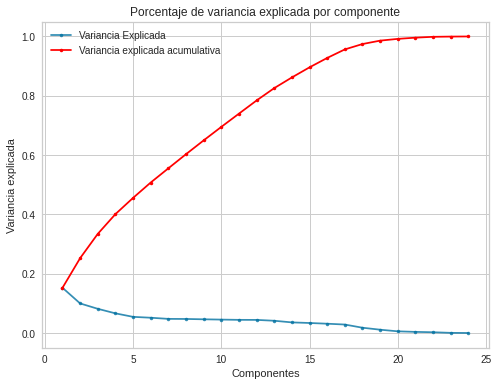

In [ ]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         pca.explained_variance_ratio_ , alpha=0.8, marker='.',
         label="Variancia Explicada");

y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');

plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red', marker='.',
         label="Variancia explicada acumulativa");
         
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Vemos en estos gráficos la varianza representada en función de las componentes utilizadas.

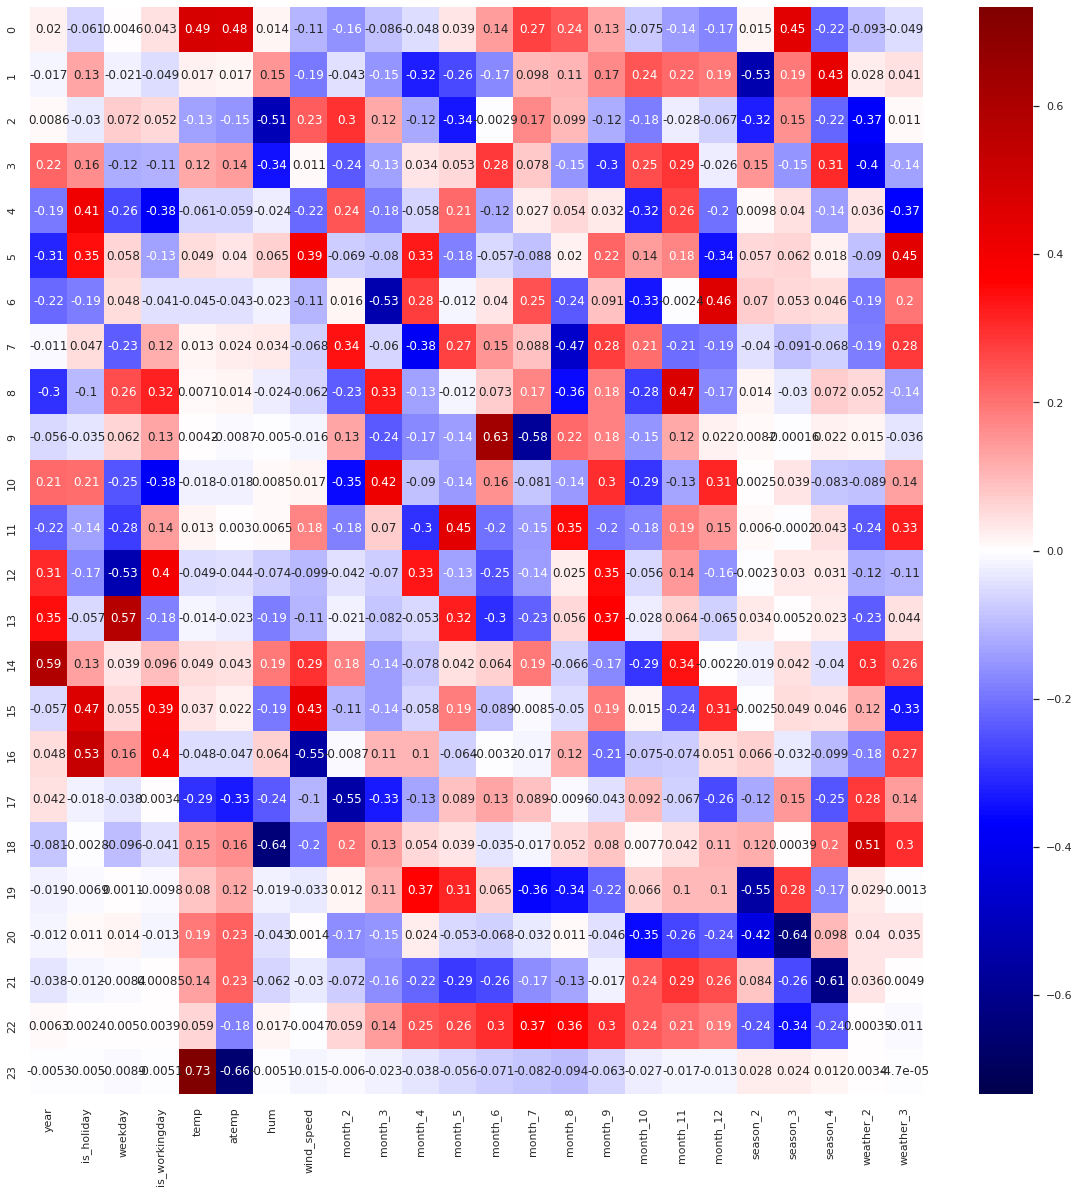

In [ ]:
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(pca.components_, cmap='seismic',
            xticklabels=X_train.columns,
            vmin=-np.max(np.abs(pca.components_)),
            vmax=np.max(np.abs(pca.components_)),
            annot=True);

Aquí podemos ver representados los pasos que se asigan a cada uno de los atributos para cada una de las componentes.

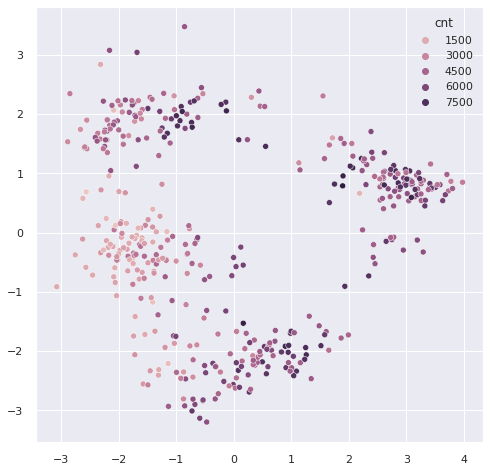

In [ ]:
X_trans = pca.transform(X_train)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train);

Habiendo esocgido 13 componentes, suena algo confuso intentar representar la disitrbución de los valores en unicamente dos dimensiones. En la gráfica podemos llegar a ver una clara separación, aún así, nos estamos perdiendo detalles dado que hay otras dimensiones que nos representamos.

In [ ]:
fig = px.scatter_3d(X_train, x=X_trans[:,0], y=X_trans[:,1], z=X_trans[:,3], color=y_train)
fig.show();

Ahora podemos ver con algo más de claridad la distinción entre los rangos de la variable objetivo. A pesar de que hay más dimensiones que no estamos pudiendo representar podemos ver razonablemente bien los distintos valores. 

## Apartado c

Tal y como hemos visto la variable a predecir es un conteo. En este caso podría tener sentido utilizar un regresor que use un modelo adecuado para este tipo de datos como el PoissonRegressor de scikit-learn. Vamos a ajustar el modelo con los datos de entrenamiento y a calcular la calidad
del modelo con los datos de test.

En primer lugar calculamos cual es la mejor alpha, usando validación cruzada

In [ ]:
from sklearn.linear_model import PoissonRegressor
from sklearn import metrics

alphas = np.linspace(0, 600, 601)

kf = KFold(n_splits=5)
bestAlpha = 0
smallestError = 1
nmseForAlpha = []
for alpha in alphas:
  fold_nmse = []
  for train_index, test_index in kf.split(X_train):
      x_train_fold = X_train.values[train_index]
      y_train_fold = y_train.values[train_index]
      x_test_fold = X_train.values[test_index,:]
      y_test_fold = y_train.values[test_index]
      
      pr = PoissonRegressor(alpha=alpha).fit(x_train_fold,y_train_fold)
      y_pred_fold = pr.predict(x_test_fold)
      fold_nmse.append(1-r2_score(y_test_fold, y_pred_fold))
  meanError = sum(fold_nmse)/5
  nmseForAlpha.append(meanError)
  if meanError < smallestError:
    bestAlpha = alpha
    smallestError = meanError


<Figure size 720x504 with 0 Axes>

Text(0.5, 1.0, 'Poisson Alpha error')

Text(0.5, 0, 'α')

Text(0, 0.5, 'Normalized mean standard error\n')

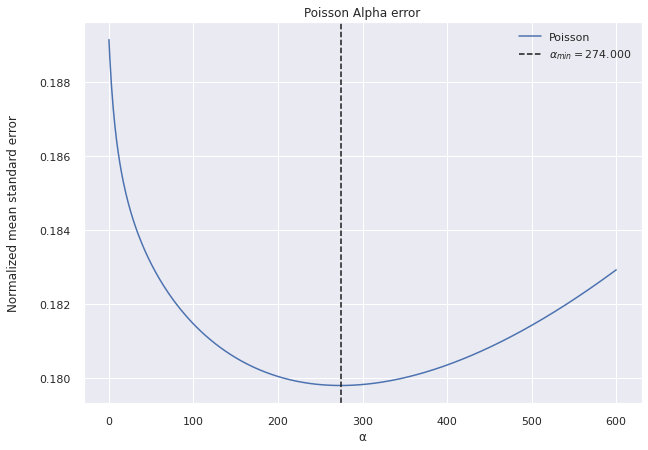


Alpha with the smallest error:  274.0  , has an error of:  0.1798103502364438


In [ ]:
plt.figure(figsize=(10, 7));
plt.plot(alphas, nmseForAlpha, label="Poisson");

plt.title("Poisson Alpha error");
plt.xlabel('α') ;
plt.ylabel('Normalized mean standard error\n');
label = "$\\alpha_{{min}}={:0.3f}$".format(bestAlpha)
plt.axvline(bestAlpha, color="k", linestyle="dashed", label=label);
plt.legend(loc='upper right');
plt.show();

print("\nAlpha with the smallest error: ", bestAlpha, " , has an error of: ", smallestError)


In [ ]:
pr = PoissonRegressor(alpha=bestAlpha)

pr.fit(X_train, y_train)

y_pred = pr.predict(X_test)

r2_test = metrics.r2_score(y_test, y_pred)

print(r2_test)

PoissonRegressor(alpha=274.0)

0.8018799341790832


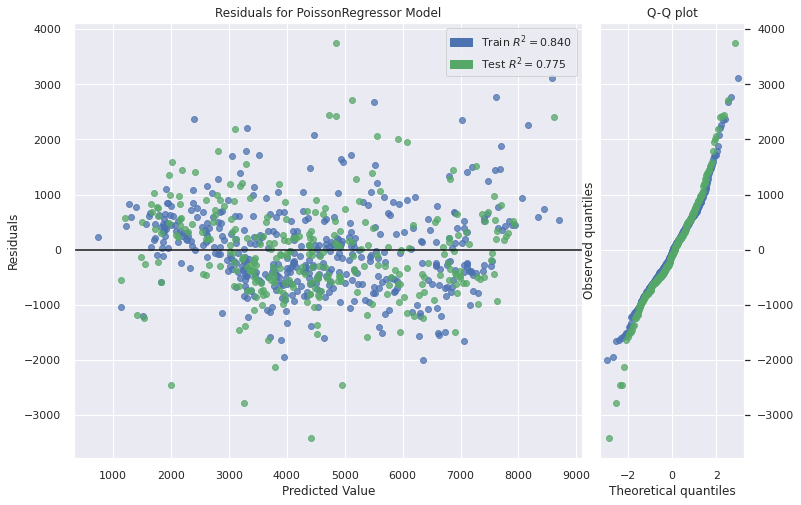

In [ ]:
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(pr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

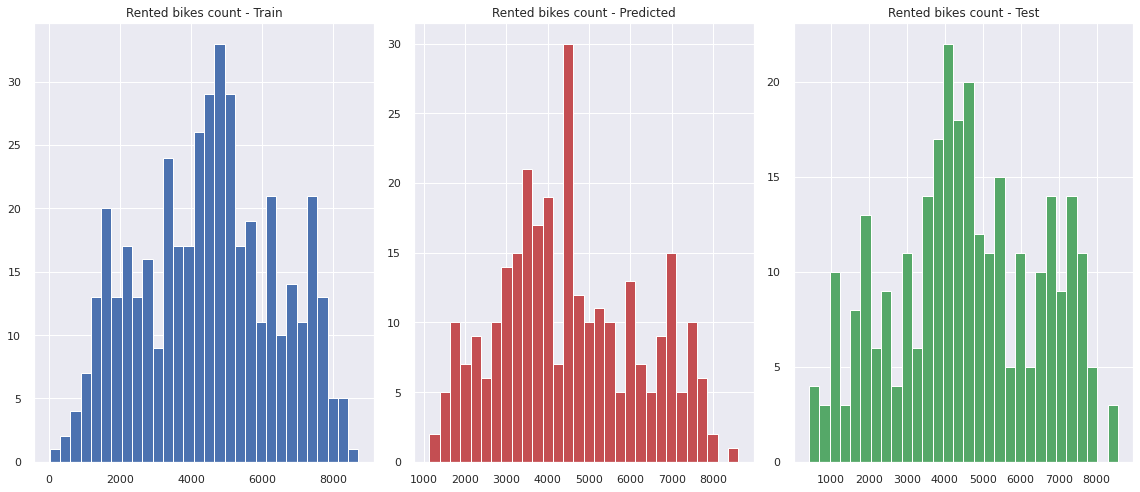

In [ ]:
y_pred = pd.Series(y_pred);
plt.figure(figsize=(16, 7));
plt.subplot(1, 3, 1);
plt.title("Rented bikes count - Train");
y_train.hist(bins=30, color='b');
plt.subplot(1, 3, 2,);
plt.title("Rented bikes count - Predicted");
y_pred.hist(bins=30, color='r');
plt.subplot(1, 3, 3);
plt.title("Rented bikes count - Test");
y_test.hist(bins=30, color='g');
plt.tight_layout();

Hemos obtenido que con una alpha de 313 tenemos la mejor aproximación, que nos da una precisión de alrededor de 80%.

## Apartado d

Ahora vamos a ajusgar una regresión lineal a los datos y calcularemos la calidad del modelo empleando validación cruzada y con los datos de test.

In [ ]:
from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats


#### Scikit-learn linear regression

Utilizamos los modelos scikit-klearn para la regresión lineal.

In [ ]:
# Instanciamos el modelo LinearRegression 
lr = LinearRegression();

# Ajustamos con los datos de entrenamiento con el método fit
lr.fit(X_train,y_train);

# Predecimos con el método predict 
y_pred = lr.predict(X_test); 

In [ ]:
weights = lr.coef_
intercept = lr.intercept_
# Podemos acceder a información del modelo, como los pesos.
print('Coeficientes: \n', weights[:10])
print('Interceptor: \n', intercept)

Coeficientes: 
 [1020.27685399  -53.91922236   97.78216453   93.27713428  680.97168494
   68.40654052 -217.83662877 -169.43163979   43.4876952   165.02497493]
Interceptor: 
 4477.988584474886


Podemos obtener un gráfico de los residuos del entrenamiento y el test con el _qqplot_ o el _histograma_ con la librería `yellowbrick`.

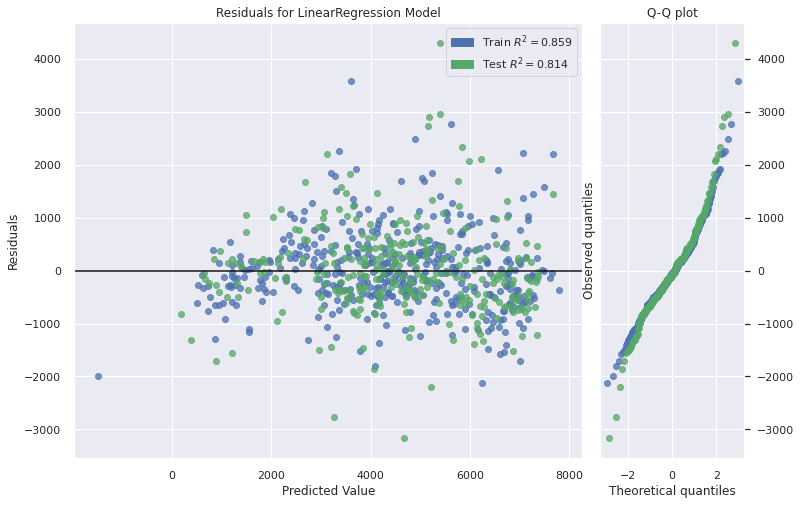

In [ ]:
#gráfico de los residuos del entrenamiento y el test con el qqplot o el histograma con la librería yellowbrick
from yellowbrick.regressor import residuals_plot
plt.figure(figsize=(12,8));
viz = residuals_plot(lr, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);

Para validar la regresión lineal podemos utiliza plot de residuos. El plot anterior es un plot con residuos buenos ya  que todos los puntos estan dispersos aleatoriamente alrededor del eje horizontal y distribuidos de forma simétrica. El Q-Q plot podemos observar los residuos estan distribuidos de forma normal.

También podemos representar las predicciones respecto a los valores reales y ver cuanto se desvían de la predicción ideal.

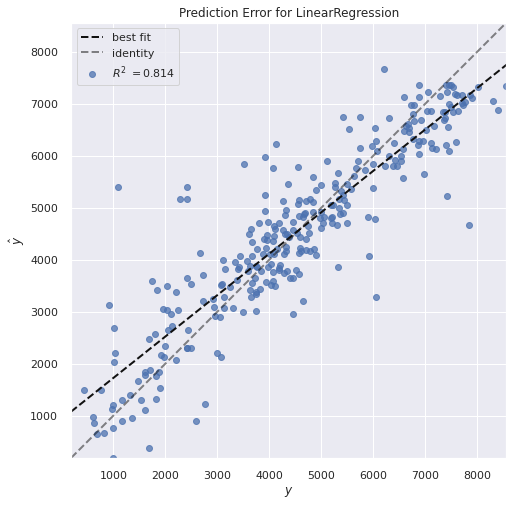

In [ ]:
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8));
visualizer = prediction_error(lr, X_test, y_test, is_fitted=True);

R² és la proporción de la variabilidad objetivo que explica el modelo, es decir, la correlación que existe entre el valor real y predecido en este caso alcanza ~81,4%.



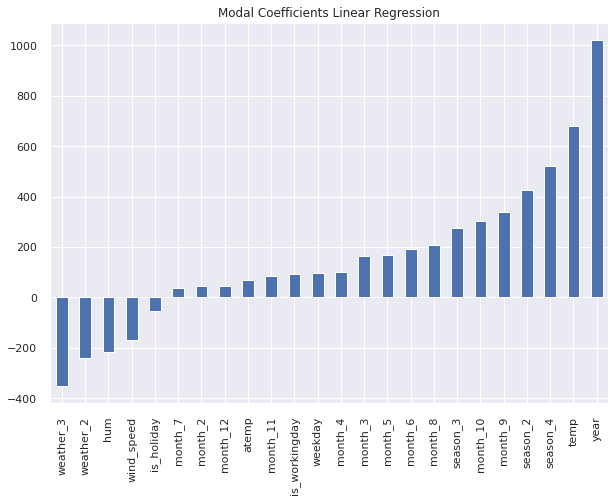

In [ ]:
predictors = X_train.columns

coef = pd.Series(lr.coef_,predictors).sort_values()

plt.figure(figsize=(10, 7));
coef.plot(kind='bar', title='Modal Coefficients Linear Regression');





####Calidad de la regresión lineal mediante la validación cruzada

Para valorar la calidad del nuestro modelo, necesitamos un conjunto de datos que no sea el de entrenamiento ni el conjunto de prueba, usaremos **Validación cruzada** para calcular las nuestra métricas.

In [ ]:
cross_val_metrics = pd.DataFrame(columns=['MSE', 'norm_MSE', 'R2'])

kf = KFold(n_splits=5)
i=1
for train_index, test_index in kf.split(X_train):
    print('Split {}: \n\tTest Folds: [{}] \n\tTrain Folds {}'.format(i, i, [j for j in range(1,6) if j != i]));
    
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]
    
    lr = LinearRegression().fit(x_train_fold,y_train_fold)
    y_pred_fold = lr.predict(x_test_fold)
    fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)
    print(f'\tMSE: {fold_mse:3.3f} NMSE: {fold_nmse:3.3f} R2: {fold_r2:3.3f}')

    cross_val_metrics.loc[f'Fold {i}', :] = [fold_mse,fold_nmse, fold_r2]
    i+=1

Split 1: 
	Test Folds: [1] 
	Train Folds [2, 3, 4, 5]
	MSE: 505406.874 NMSE: 0.137 R2: 0.863
Split 2: 
	Test Folds: [2] 
	Train Folds [1, 3, 4, 5]
	MSE: 758537.824 NMSE: 0.218 R2: 0.782
Split 3: 
	Test Folds: [3] 
	Train Folds [1, 2, 4, 5]
	MSE: 699256.157 NMSE: 0.217 R2: 0.783
Split 4: 
	Test Folds: [4] 
	Train Folds [1, 2, 3, 5]
	MSE: 624869.423 NMSE: 0.176 R2: 0.824
Split 5: 
	Test Folds: [5] 
	Train Folds [1, 2, 3, 4]
	MSE: 652503.647 NMSE: 0.143 R2: 0.857


Donde MSE es el error cuadrático medio, norm_MSE el error cuadrático normalizado y R2 el coeficiente de determinación.

In [ ]:
cross_val_metrics.loc['Mean',:] = cross_val_metrics.mean()
cross_val_metrics

,MSE,norm_MSE,R2
Fold 1,505406.874,0.137,0.863
Fold 2,758537.824,0.218,0.782
Fold 3,699256.157,0.217,0.783
Fold 4,624869.423,0.176,0.824
Fold 5,652503.647,0.143,0.857
Mean,648114.785,0.178,0.822


A partir de la media de los cinco folds podemos observar que la calidad es regularmente buena, ya que MSE normalizado es ~0.178 que aproxima el 0 y R2 alcanza un ~0.822.

In [ ]:
lr = LinearRegression().fit(X_train,y_train);
folds_r2 = cross_val_score(lr, X_train,y_train, cv=5, scoring='r2')
lr_r2 = np.mean(folds_r2) 
folds_r2, lr_r2

(array([0.86336617, 0.78241399, 0.78325299, 0.82367055, 0.85682837]),
 0.8219064146507618)

## Apartado e

Cuando se trata de entender un problema, es útil reducir el número de atributos en el modelo. Por eso mismo, vamos a ajutar una regresión LASSO y a calcular la calidad del modelo con los datos de test.

In [ ]:
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]

lasso_cv =LassoCV(alphas=lambdas, cv=5 ).fit(X_train,y_train)

lasso =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso)

Best lambda: 10.0 R2 score: 0.8267984192963611


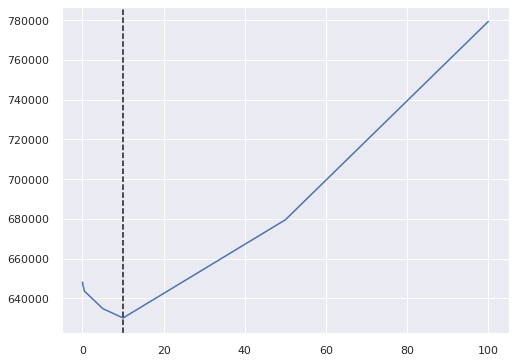

In [ ]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(LassoCV(alphas=lambdas));
vis.fit(X_train, y_train);

In [ ]:
results = pd.DataFrame({'lr':lr_r2, 'lasso_cv':lasso}, index = ['CV R2'])

results.loc['Train R2', :] = [r2_score(y_train,lr.predict(X_train)),
                                r2_score(y_train,lasso_cv.predict(X_train))]
results.loc['lambda','lr'] = 0

results.loc['lambda','lasso_cv'] = lasso_cv.alpha_

results

,lr,lasso_cv
CV R2,0.822,0.827
Train R2,0.859,0.857
lambda,0.000,10.000


<Figure size 720x504 with 0 Axes>

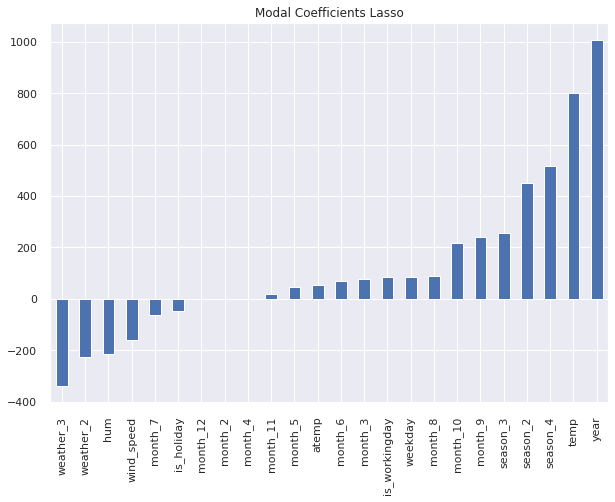

In [ ]:
predictors = X_train.columns

coef = pd.Series(lasso_cv.coef_,predictors).sort_values()

plt.figure(figsize=(10, 7));
coef.plot(kind='bar', title='Modal Coefficients Lasso')

## Apartado f

Por último vamos a analizar y comparar los valores pronosticados con los valores reales de los tres modelos y sus calidades.


Recordando los valores que hemos obtenido en los modelos a la hora de probar los conjuntos de test tenemos los siguientes resultados:
- Poission: 0.775
- Linear regression: 0.814
- LASSO: 0.827

Como podemos observar, el primer modelo que utilizamos, porque era el que más lógica tenía, ha resultado ser el modelo con el peor resultado, a pesar de que no es del todo malo. Como mejor resultado tenemos el modelo LASSO, por lo que podemos decir que de los tres, es el mejor de los modelos que hemos ajustado.

Como hemos podido ver en las gráficas de coeficientes, las variables más importantes son el año, la temperatura, y la estación.

En el caso de Lasso, la pertenencia a los meses de diciembre, febrero y abril es directamente considerada 0, son variables no relevantes. En el caso de regresión lineal tienen muy poco peso igualmente.

A priori tal y como hemos comentado, Poisson parecía la mejor opción en cuanto a modelo ya que este se suele usar cuando la variable objetivo es un conteo (valores enteros no negativos). Por otro lado LASSO suele utilizarse cuando los datos presentan una gran multicolinealidad.

Podemos deducir en este caso, que tal y como trabaja LASSO, disminuyendo el impacto de los atributos menos importante a practicamente 0, ha ayudado a obtener mejores resultados. Tal y como hemos visto en algunas gráficas, la importancia a la hora de predecir un valor, recae en únicamente en unas pocas variables, de ahí que al final de resultados mejores que otros modelos.